In [239]:
%store -r time_series

In [240]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import fbprophet
from neuralprophet import NeuralProphet

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log
import numpy as np
import pandas as pd
import datetime as dt

In [241]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast-actual)/np.abs(actual))
    me = np.mean(forecast-actual)
    mae = np.mean(np.abs(forecast-actual))
    mpe = np.mean((forecast-actual)/actual)
    rmse = np.mean((forecast-actual)**2)**0.5
    corr = np.corrcoef(forecast, actual)[0,1]
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)
    acfe = acf(forecast - actual)[1]

    return ({'mape':mape, 'me':me, 'mae':mae, 'mpe':mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax, 'acfe':acfe})

In [242]:
def create_plot(x_train: np.array, y_train:np.array, x_test: np.array, y_test: np.array, forecast: np.array, fontsize: int, lower: np.array = None, upper: np.array = None):
    sns.lineplot(x=x_train, y=y_train, label='train data')
    sns.lineplot(x=x_test, y=y_test, label='test data')
    sns.lineplot(x=x_test, y=forecast, label='forecast')
    if lower is not None and upper is not None:
        plt.fill_between(x_test, lower, upper, color='k', alpha=0.15)
    plt.title('forecast vs actual')
    plt.legend(loc = 'upper right', fontsize=fontsize)

In [243]:
def configure_plot(figsize: tuple, ylim: tuple, xlim: tuple):
    plt.figure(figsize=figsize)
    plt.ylim(ylim)
    plt.xlim(xlim)


In [244]:
def my_plot(x_train: np.array, y_train:np.array, x_test: np.array, y_test: np.array, forecast: np.array, 
*, figsize: tuple = (12, 5), fontsize: int = 8, ylim: tuple = (-0.60*pow(10,7),0.4*pow(10,8)), xlim: tuple = (17000, 17200), 
lower: np.array = None, upper: np.array = None):
    configure_plot(figsize, ylim, xlim)
    if lower is not None and upper is not None:
        create_plot(x_train, y_train, x_test, y_test, forecast, fontsize, lower, upper)
    else:
        create_plot(x_train, y_train, x_test, y_test, forecast, fontsize)
    plt.show()

elimino le prime 1500 righe e le ultime 1500 righe per prendere solo una porzione della time series

In [245]:
time_series.drop(time_series.index[:1500], inplace=True)
time_series.drop(time_series.index[-1500:], inplace=True)
x_train, x_test, y_train, y_test = train_test_split(time_series.time, time_series.avg_bytes, test_size=0.2, shuffle=False)

In [246]:
result = adfuller(y_train)
print('ADF statistics: %f', result[0])
print('p-value : %f', result[1])

ADF statistics: %f -2.209274470929484
p-value : %f 0.20289659573034496


In [247]:
x_train = x_train.map(dt.datetime.fromordinal)
x_test = x_test.map(dt.datetime.fromordinal)

setting dello stile

In [248]:
plt.rcParams.update({'figure.figsize':(15,12), 'figure.dpi':120})
sns.set(style='darkgrid')

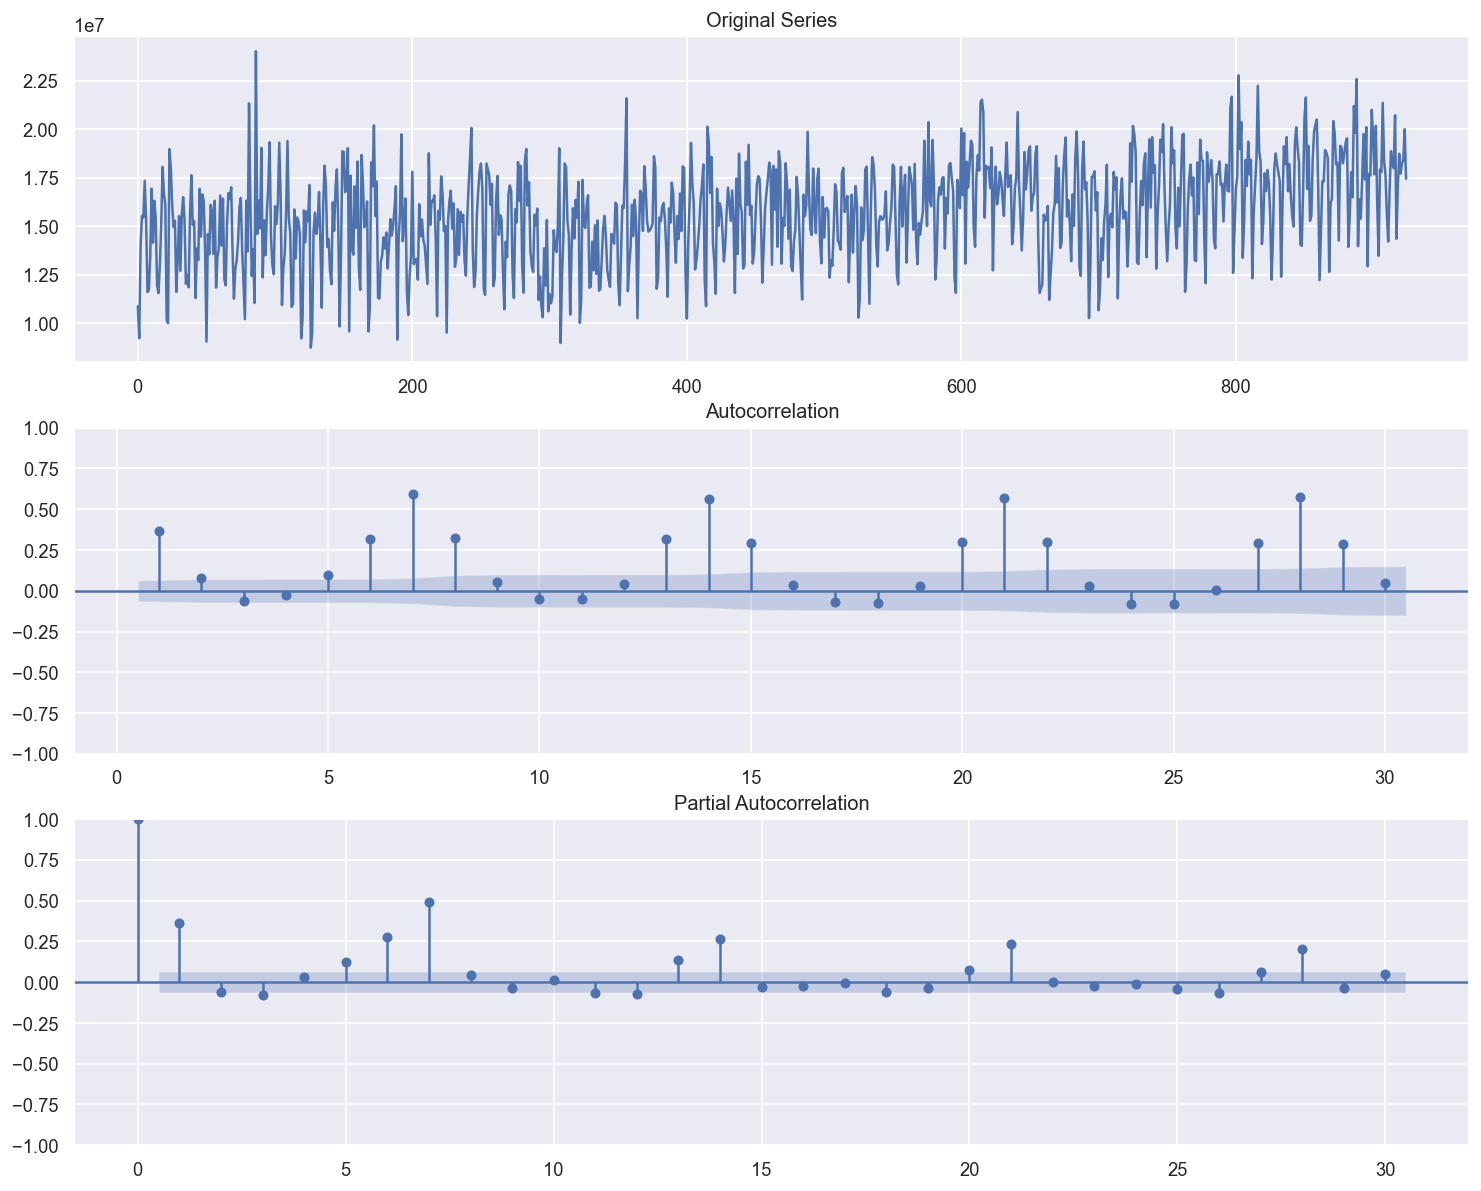

In [249]:
fig, axes = plt.subplots(3, 1)
axes[0].plot(y_train.values)
axes[0].set_title('Original Series')
plot_acf(y_train.values, ax=axes[1], zero=False, alpha=0.05)
plot_pacf(y_train.values, ax=axes[2], alpha=0.05, method='ywm')
plt.show()

In [250]:
result = adfuller(y_train.diff().dropna())
print('ADF statistics: %f', result[0])
print('p-value : %f', result[1])

ADF statistics: %f -12.107150571395064
p-value : %f 1.9570164650228551e-22


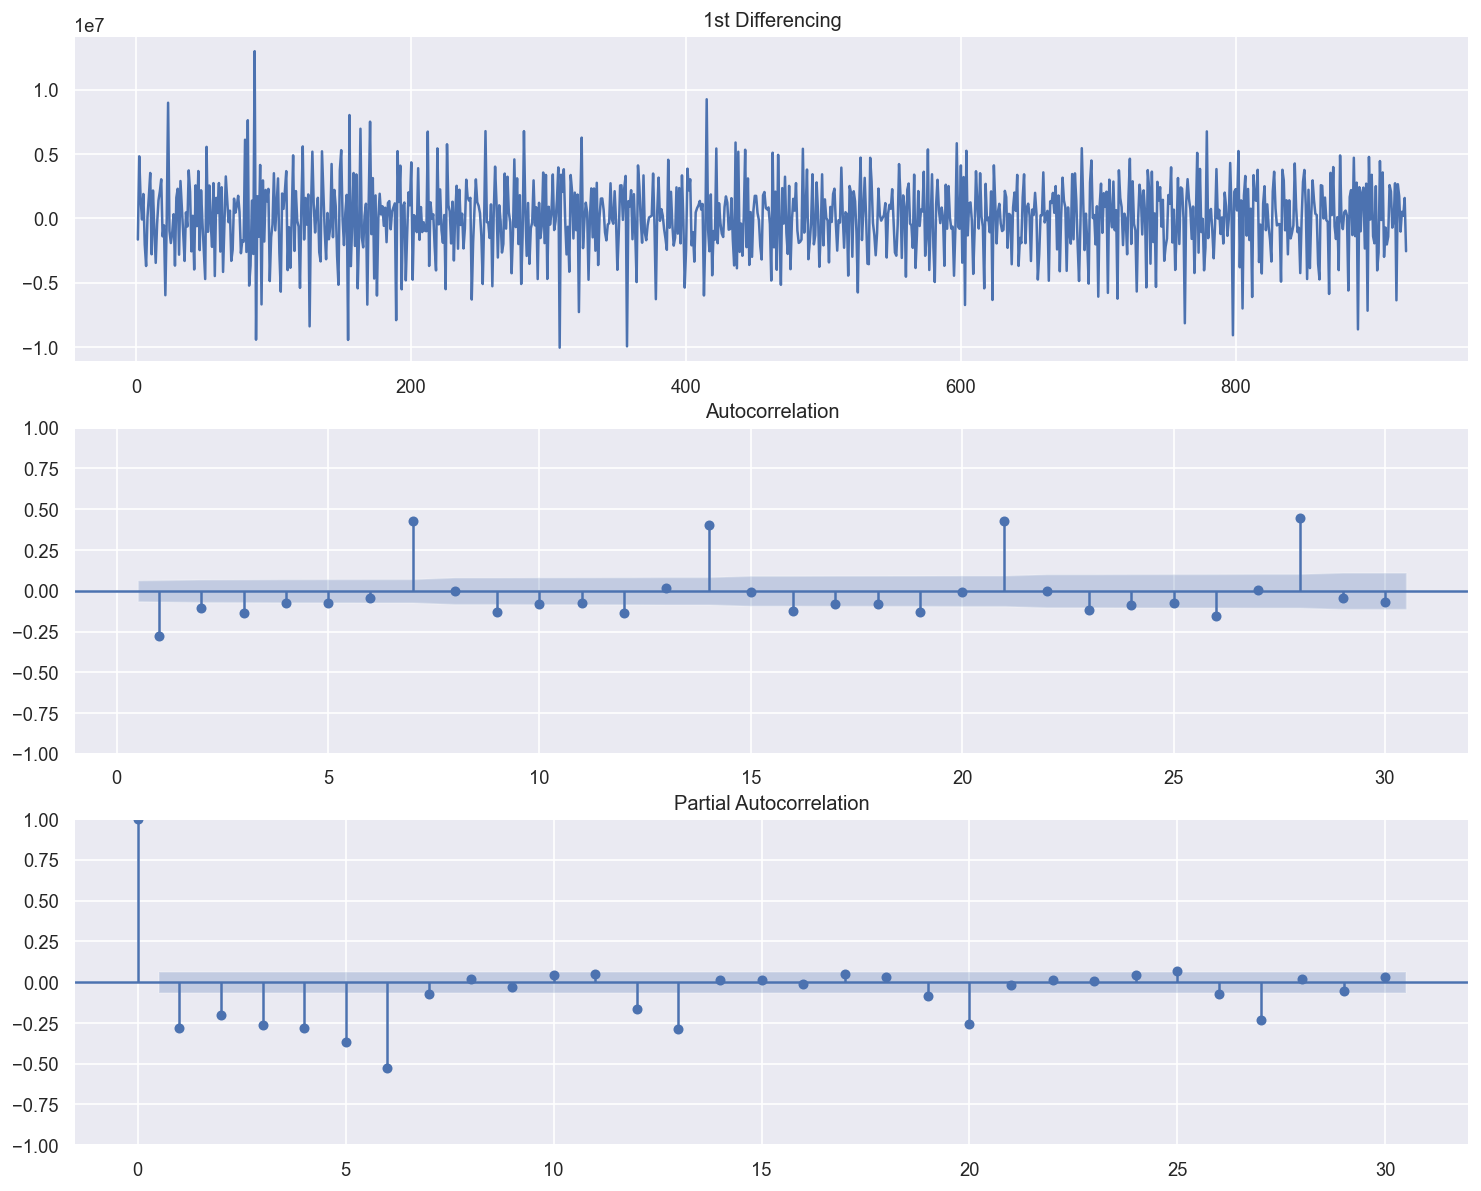

In [251]:
fig, axes = plt.subplots(3, 1)
axes[0].plot(y_train.diff().values)
axes[0].set_title('1st Differencing')
plot_acf(y_train.diff().dropna().values, ax=axes[1], zero=False, alpha=0.05)
plot_pacf(y_train.diff().dropna().values, ax=axes[2], alpha=0.05, method='yw')
plt.show()

#### p può essere fissato a 1 stando al grafico della partial autocorrelation

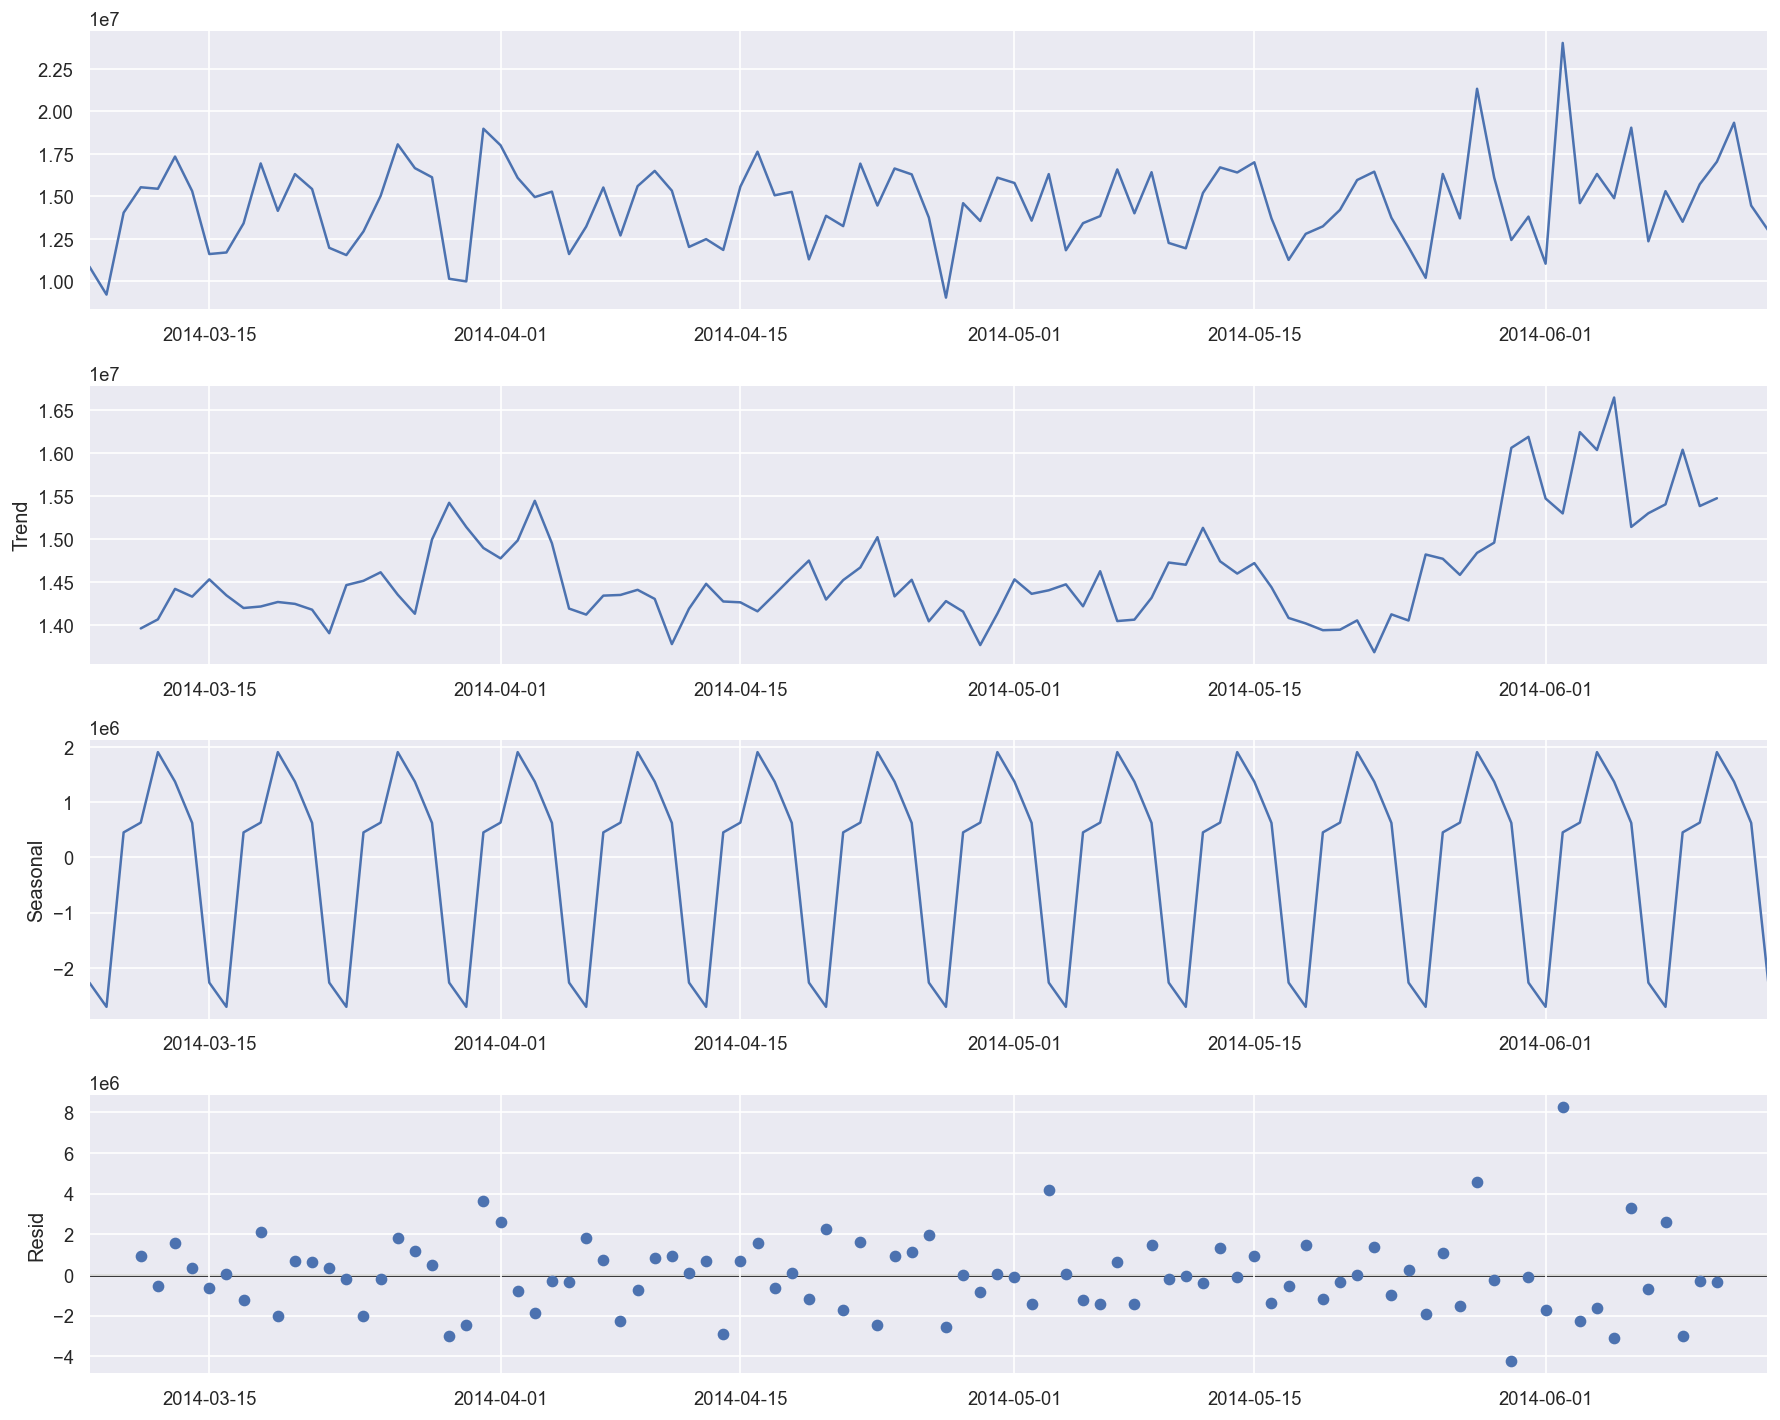

In [252]:
seasonal = pd.concat([x_train, y_train], axis=1)
seasonal.set_index('time', inplace=True)
result = sm.tsa.seasonal_decompose(seasonal.iloc[:99], model='additive')
result.plot()
plt.show()

##### P potrebbe essere 6 in base al grafico della partial autocorrelation differenziata, mentre q può essere 1

In [253]:
train = pd.Series(y_train.values, index=x_train.values, name='byte')
test = pd.Series(y_test.values, index=x_test.values, name='byte')

In [254]:
model = sm.tsa.arima.ARIMA(train.values, order=(4,1,5))
fitted = model.fit()
forecast_arima = fitted.predict(start=len(y_train.values), end=len(y_train.values)+len(y_test.values)-1, dynamic=False)
print(fitted.summary())

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

  warnings.warn("Maximum Likelihood optimization failed to "



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  925
Model:                 ARIMA(4, 1, 5)   Log Likelihood              -14696.380
Date:                Tue, 20 Jun 2023   AIC                          29412.760
Time:                        19:41:01   BIC                          29461.047
Sample:                             0   HQIC                         29431.183
                                - 925                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5185      0.053     -9.870      0.000      -0.621      -0.415
ar.L2          0.2594      0.029      9.051      0.000       0.203       0.316
ar.L3         -0.5889      0.027    -21.946      0.0

ARIMA base

In [255]:
forecast_arima = fitted.forecast(steps=232)
fc_obj = fitted.get_forecast(steps=232)
conf = fc_obj.summary_frame(alpha=0.15)
stderr = fitted.bse

In [256]:
lower_series = pd.Series(conf['mean_ci_lower'].values, index=x_test.values)
upper_series = pd.Series(conf['mean_ci_upper'].values, index=x_test.values)

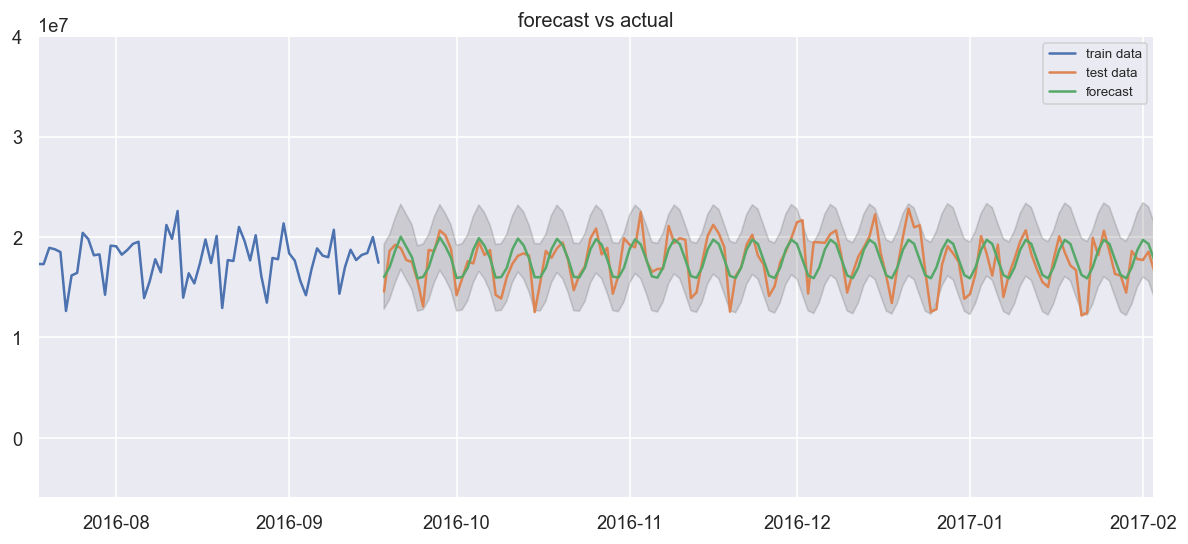

In [257]:
my_plot(x_train=train.index, y_train=train.values, x_test=test.index, y_test=test.values, lower=lower_series.values, upper=upper_series.values, forecast=forecast_arima)

Sarimax base

In [258]:
model = sm.tsa.SARIMAX(train.values, order=(4,1,5), trend='c')
fitted = model.fit()
forecast_sarimax = fitted.forecast(steps=232)
fc_obj = fitted.get_forecast(steps=232)
conf = fc_obj.summary_frame(alpha=0.15)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60158D+01    |proj g|=  5.53106D-01

At iterate    5    f=  1.59588D+01    |proj g|=  1.29522D-01

At iterate   10    f=  1.59275D+01    |proj g|=  5.56949D-02

At iterate   15    f=  1.59140D+01    |proj g|=  2.12948D-01

At iterate   20    f=  1.59099D+01    |proj g|=  1.26784D-01

At iterate   25    f=  1.59017D+01    |proj g|=  1.23841D+00

At iterate   30    f=  1.58955D+01    |proj g|=  1.45697D+00

At iterate   35    f=  1.58924D+01    |proj g|=  3.46667D-02

At iterate   40    f=  1.58889D+01    |proj g|=  8.38375D-01


WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

  warnings.warn("Maximum Likelihood optimization failed to "




At iterate   45    f=  1.58879D+01    |proj g|=  8.05515D-02

At iterate   50    f=  1.58878D+01    |proj g|=  1.41619D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     63      1     0     0   1.416D-02   1.589D+01
  F =   15.887813847889618     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [259]:
lower_series = pd.Series(conf['mean_ci_lower'].values, index=x_test.values)
upper_series = pd.Series(conf['mean_ci_upper'].values, index=x_test.values)

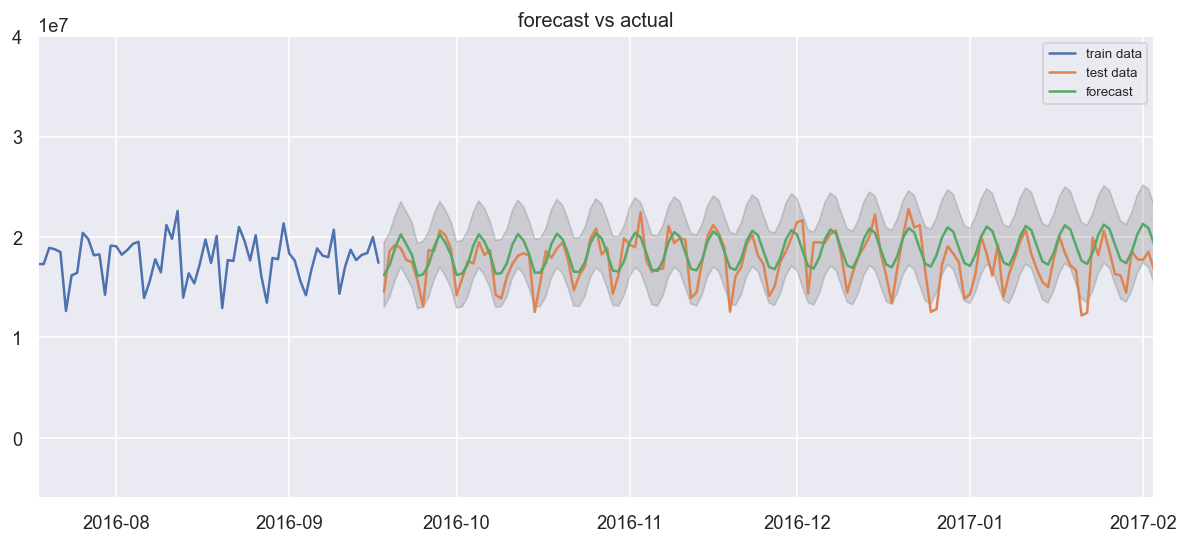

In [260]:
my_plot(x_train=train.index, y_train=train.values, x_test=test.index, y_test=test.values, lower=lower_series, upper=upper_series, forecast=forecast_sarimax)

prophet base

In [261]:
ts = time_series.copy()
ts['time'] = ts['time'].map(dt.datetime.fromordinal)
ts.rename(columns={'time':'ds', 'avg_bytes':'y'}, inplace=True)
train, test = train_test_split(ts, test_size=0.2, shuffle=False)

In [262]:
model = fbprophet.Prophet(daily_seasonality=True,
                          weekly_seasonality=True)
fitted = model.fit(train)
forecast_prophet = fitted.predict(test)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



Initial log joint probability = -8.97539
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2049.93    0.00115824       137.482      0.7595      0.7595      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       2050.13    0.00045539       216.369    4.79e-06       0.001      173  LS failed, Hessian reset 
     120       2050.34   0.000163042       115.201   9.772e-07       0.001      224  LS failed, Hessian reset 
     163       2050.58   0.000215786       112.617   2.365e-06       0.001      328  LS failed, Hessian reset 
     199       2050.64   0.000137024            62           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       2050.67   2.88454e-07       66.0188     0.05339      0.3952      433   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

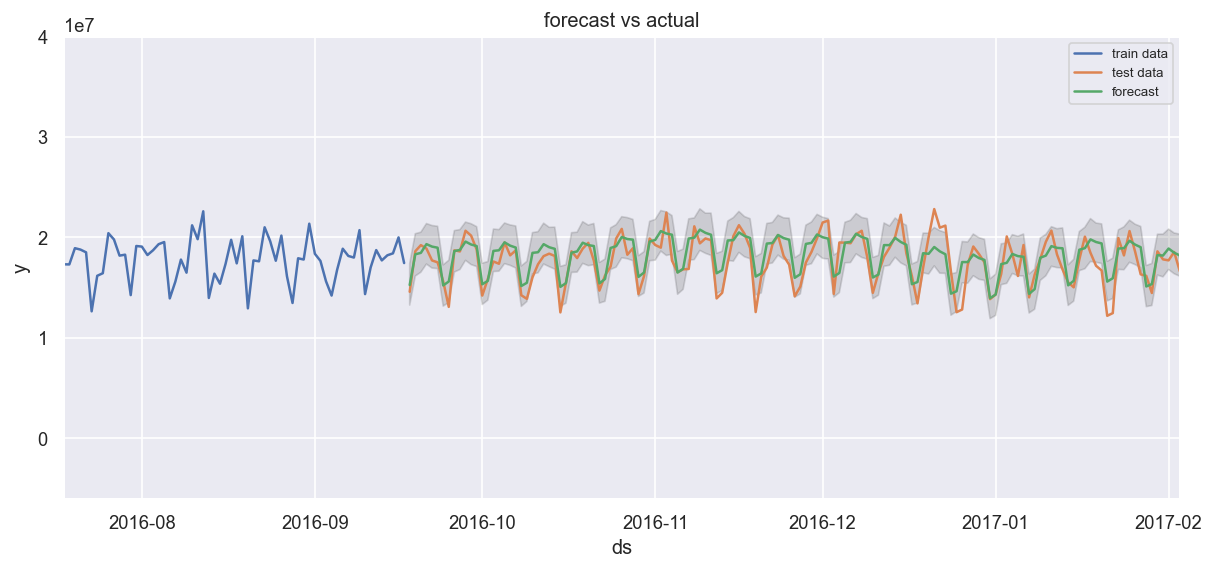

In [263]:
my_plot(x_train=train.ds, y_train=train.y, x_test=test.ds, y_test=test.y, forecast=forecast_prophet.yhat.values, lower=forecast_prophet.yhat_lower.values, upper=forecast_prophet.yhat_upper.values)

Neural Prophet base

In [264]:
train_np ,validation = train_test_split(train, test_size=0.1, shuffle=False)

In [ ]:
model = NeuralProphet(
    daily_seasonality=True,
    weekly_seasonality=True)
fitted = model.fit(df=train_np, validation_df=validation, freq='D', epochs=1000, batch_size=32, learning_rate=1e-3, early_stopping=True, metrics=True)
forecast_neuralprohet = model.predict(test)

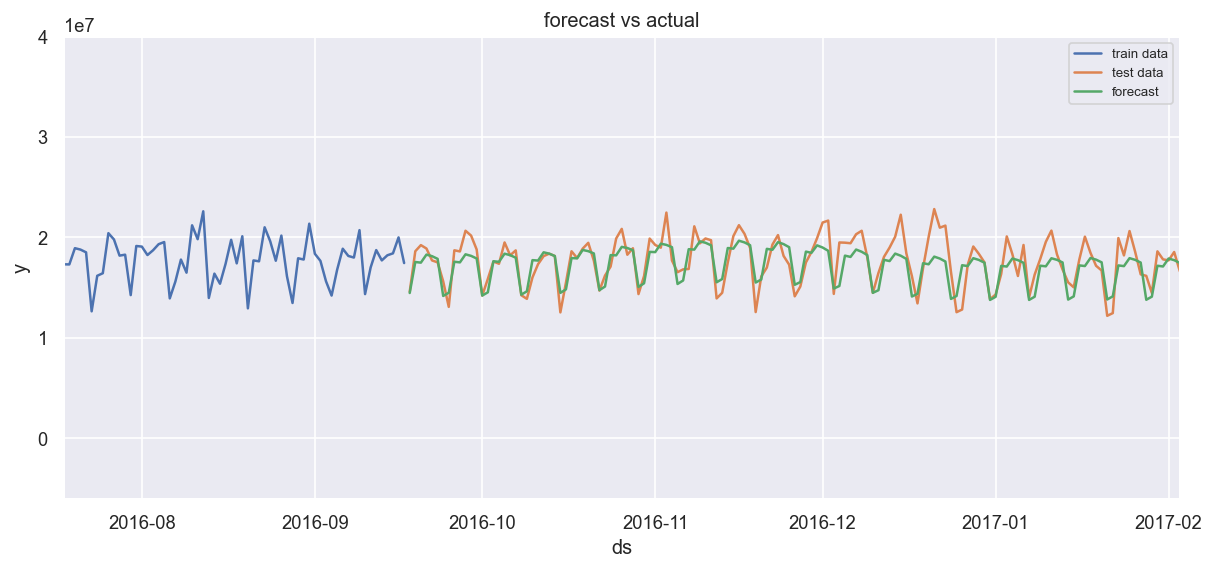

In [266]:
my_plot(x_train=train.ds, y_train=train.y, x_test=test.ds, y_test=test.y, forecast=forecast_neuralprohet.yhat1.values)

arima con aggiornamento

In [267]:
train = pd.Series(y_train.values, index=x_train.values, name='byte')
test = pd.Series(y_test.values, index=x_test.values, name='byte')

In [268]:
nforecasts = 3
forecasts = {}
model = sm.tsa.arima.ARIMA(train.values, order=(1,1,0))
fitted = model.fit()
forecasts[train.index[-1]+dt.timedelta(days=1)] = fitted.forecast(steps=nforecasts)

In [269]:
for t in range(len(test)):
    print(test.iloc[t:t+1])
    updated_endog = test.iloc[t:t+1]
    fitted = fitted.append(updated_endog.values, refit=True)
    forecasts[updated_endog.index[0]+dt.timedelta(days=1)] = fitted.forecast(steps=nforecasts)

2016-09-18    1.458354e+07
Name: byte, dtype: float64
2016-09-19    1.861829e+07
Name: byte, dtype: float64
2016-09-20    1.922852e+07
Name: byte, dtype: float64
2016-09-21    1.888891e+07
Name: byte, dtype: float64
2016-09-22    1.770362e+07
Name: byte, dtype: float64
2016-09-23    1.751344e+07
Name: byte, dtype: float64
2016-09-24    1.562303e+07
Name: byte, dtype: float64
2016-09-25    1.308101e+07
Name: byte, dtype: float64
2016-09-26    1.871283e+07
Name: byte, dtype: float64
2016-09-27    1.859815e+07
Name: byte, dtype: float64
2016-09-28    2.065933e+07
Name: byte, dtype: float64
2016-09-29    2.017742e+07
Name: byte, dtype: float64
2016-09-30    1.879099e+07
Name: byte, dtype: float64
2016-10-01    1.420585e+07
Name: byte, dtype: float64
2016-10-02    1.586230e+07
Name: byte, dtype: float64
2016-10-03    1.759728e+07
Name: byte, dtype: float64
2016-10-04    1.737152e+07
Name: byte, dtype: float64
2016-10-05    1.949445e+07
Name: byte, dtype: float64
2016-10-06    1.821145e+07
N

In [270]:
forecasts_arima = pd.DataFrame(forecasts).T
forecasts_arima = forecasts_arima.rename(columns={0:'fc1',1:'fc2',2:'fc3'})
forecasts_arima.drop(['fc1', 'fc3'], axis=1, inplace=True)

ValueError: Data must be 1-dimensional

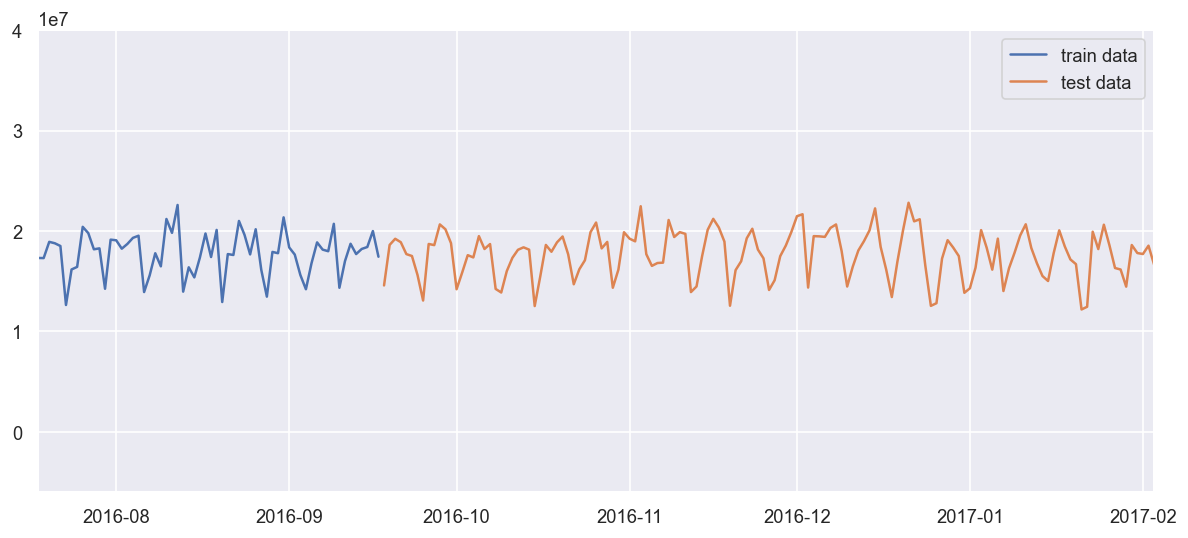

In [271]:
my_plot(x_train=train.index, y_train=train.values, x_test=test.index, y_test=test.values, forecast=forecasts_arima)

sarimax con aggiornamento

In [ ]:
nforecasts = 3
forecasts = {}
mod = sm.tsa.SARIMAX(train.values, order=(1,1,0), trend='c')
res = mod.fit()
forecasts[train.index[-1]] = res.forecast(steps=nforecasts)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62346D+01    |proj g|=  1.88367D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   1.929D-06   1.623D+01
  F =   16.234550201393301     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [ ]:
for t in range(len(test)):
    updated_endog = test.iloc[t:t+1]
    res = res.append(updated_endog.values, refit=True)
    forecasts[updated_endog.index[0]] = res.forecast(steps=nforecasts)

In [ ]:
forecasts_sarimax = pd.DataFrame(forecasts).T
forecasts_sarimax = forecasts_sarimax.rename(columns={0:'fc1',1:'fc2',2:'fc3'})

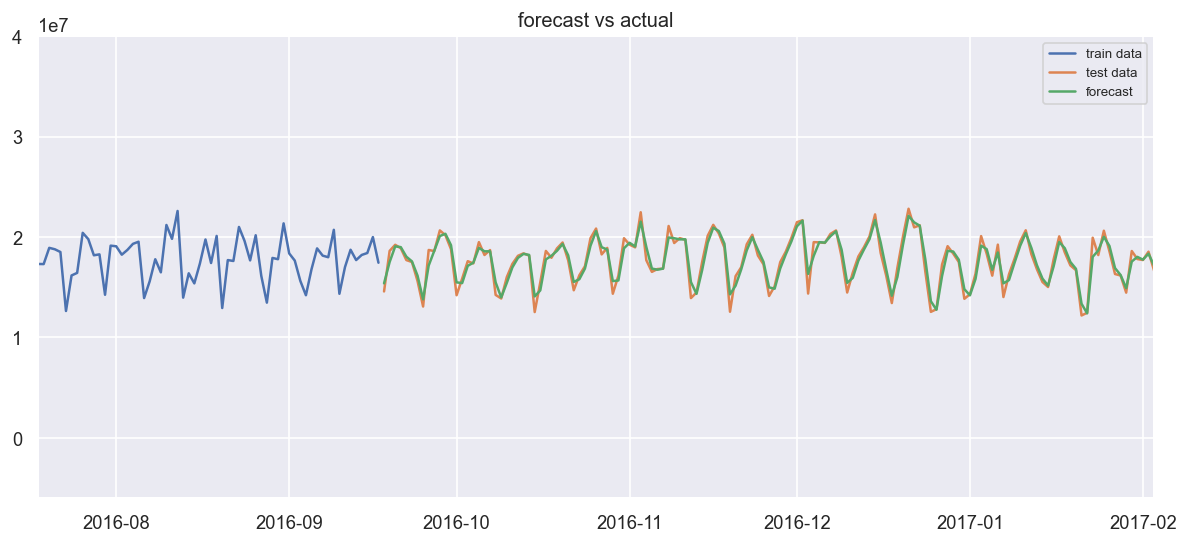

In [ ]:
my_plot(x_train=train.index, y_train=train.values, x_test=test.index, y_test=test.values, forecast=forecasts_sarimax['fc1'].values[1:])

prophet con aggiornamento dei parametri

In [273]:
train, test = train_test_split(ts, test_size=0.2, shuffle=False)

In [ ]:
model = fbprophet.Prophet(weekly_seasonality=True)
model.fit(train)
obj_list = list()
for t in range(len(test)):
    obj_list.append(fbprophet.Prophet(weekly_seasonality=True))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



Initial log joint probability = -8.97539
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2050.26    0.00104796       79.8381           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       2050.58   0.000321871       80.6119   4.395e-06       0.001      185  LS failed, Hessian reset 
     191       2050.65   1.69687e-07       60.2958           1           1      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [ ]:
nforecasts = 3
forecasts = {}

updated_endog = train
forecasts[train.index[-1]] = model.predict(test.iloc[0:3])['yhat'].values
for t in range(len(test)):
    updated_endog = pd.concat([updated_endog, test.iloc[t:t+1]], axis=0)
    obj_list[t].fit(updated_endog)
    forecasts[updated_endog.index[-1]] = obj_list[t].predict(test.iloc[t:t+3])['yhat'].values

In [ ]:
for key, value in forecasts.items():
    if len(value) < 3:
        forecasts[key] = np.pad(value, (0, 3 - len(value)), 'constant', constant_values=np.nan)

In [ ]:
forecasts_prophet = pd.DataFrame(forecasts).T
forecasts_prophet = forecasts_prophet.rename(columns={0:'fc1',1:'fc2',2:'fc3'})

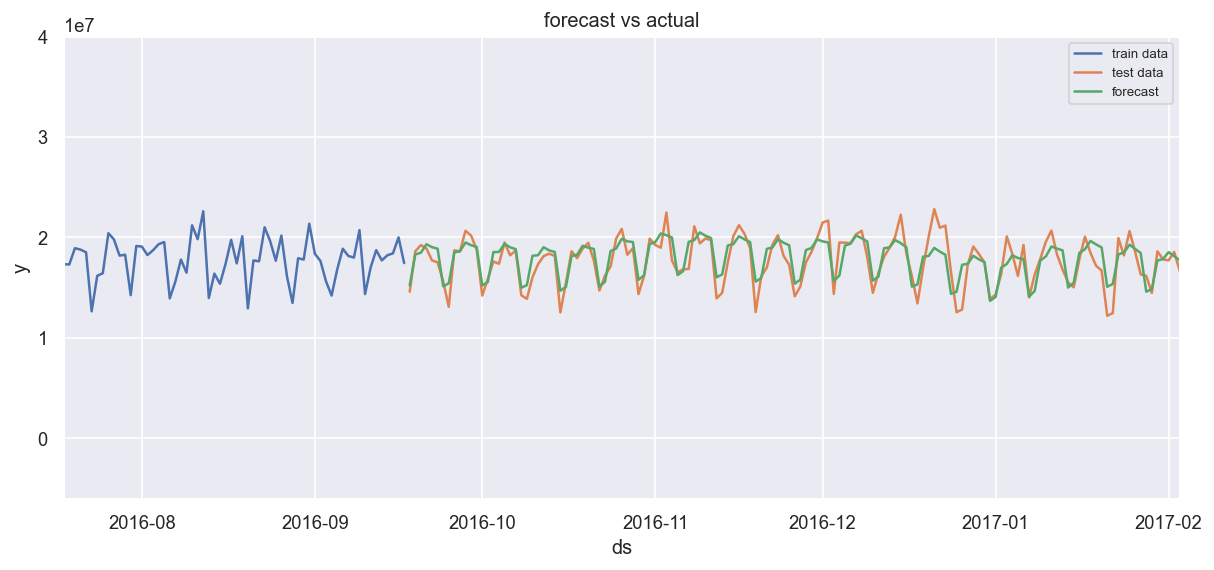

In [ ]:
my_plot(x_train=train.ds, y_train=train.y, x_test=test.ds, y_test=test.y, forecast=forecasts_prophet['fc1'].values[1:])

# Comparazione numerica dei modelli

In [274]:
print(f'ARIMA', forecast_accuracy(forecast_arima, test.y.values), "\n\n"+
'SARIMAX', forecast_accuracy(forecast_sarimax, test.y.values), "\n\n"+
'PROPHET', forecast_accuracy(forecast_prophet.yhat.values, test.y.values), "\n\n"
'NEURALPROPHET', forecast_accuracy(forecast_neuralprohet.yhat1.values, test.y.values))

ARIMA {'mape': 0.06869023106447855, 'me': -6615.86722031943, 'mae': 1182106.0695793135, 'mpe': 0.008583205220836075, 'rmse': 1504575.9838053663, 'corr': 0.7403908761198389, 'minmax': 0.0641725315739956, 'acfe': 0.09489574303641567} 

SARIMAX {'mape': 0.10337794708177458, 'me': 1345863.0793850755, 'mae': 1714228.1135524628, 'mpe': 0.08537975823281371, 'rmse': 2075923.7305875244, 'corr': 0.6992748478694042, 'minmax': 0.08965255016332252, 'acfe': 0.1810790157375358} 

PROPHET {'mape': 0.06756309828525237, 'me': 435011.9080738041, 'mae': 1151145.9440675136, 'mpe': 0.0309818451516573, 'rmse': 1474445.495956251, 'corr': 0.7715986498882162, 'minmax': 0.06217433953030704, 'acfe': 0.17310907730279756} 

NEURALPROPHET {'mape': 0.06489676755074492, 'me': -579174.8665197494, 'mae': 1170543.5906451396, 'mpe': -0.02659008713962434, 'rmse': 1526972.8505607762, 'corr': 0.7692337778773982, 'minmax': 0.06309676550809395, 'acfe': 0.16544961572182293}


In [ ]:
print(f'ARIMA updated', forecast_accuracy(forecasts_arima['fc2'].values[:232], test.y.values), "\n\n"+
'SARIMAX updated', forecast_accuracy(forecasts_sarimax['fc1'].values[1:], test.y.values), "\n\n"+
'PROPHET updated', forecast_accuracy(forecasts_prophet['fc1'].values[1:], test.y.values))

ARIMA updated {'mape': 0.11452426784526605, 'me': 8675.985383106356, 'mae': 1947680.7446640423, 'mpe': 0.012933515197099682, 'rmse': 2468719.2947340286, 'corr': 0.3096742208343579, 'minmax': 0.1027398182742485, 'acfe': 0.04758804490560098} 

SARIMAX updated {'mape': 0.02998066146213827, 'me': 13348.492196815032, 'mae': 509201.4276456378, 'mpe': 0.0036211662747020774, 'rmse': 653299.6964767259, 'corr': 0.959603162806481, 'minmax': 0.02898239648726697, 'acfe': -0.11711423785730664} 

PROPHET updated {'mape': 0.06045204695587901, 'me': 146074.86875549133, 'mae': 1042352.4023228189, 'mpe': 0.014241359993196732, 'rmse': 1353378.62190425, 'corr': 0.7935790512754297, 'minmax': 0.056694978438171395, 'acfe': 0.13693352377704388}


Risultati : Nel primo caso, SARIMAX è il modello peggiore, segue ARIMA e in fine PROPHET
Nel modello con aggioramento dei parametri invece PROPHET è la peggiore, segue SARIMAX e ARIMA al primo posto, 
questo probabilmente perché profet non ha una libreria che consente l'aggiornamento dei parametri e deve ricalcolare il modello ad ogni iterazione rendendolo anche il più inefficiente in termini di tempo.

I risultati complessivi comunque mostrano questa classifica:
1) ARIMA con aggiornamento iterativo
2) SARIMAX con aggiornamento iterativo
3) PROFET con aggiornamento iterativo
4) PROFET
5) ARIMA
6) SARIMAX


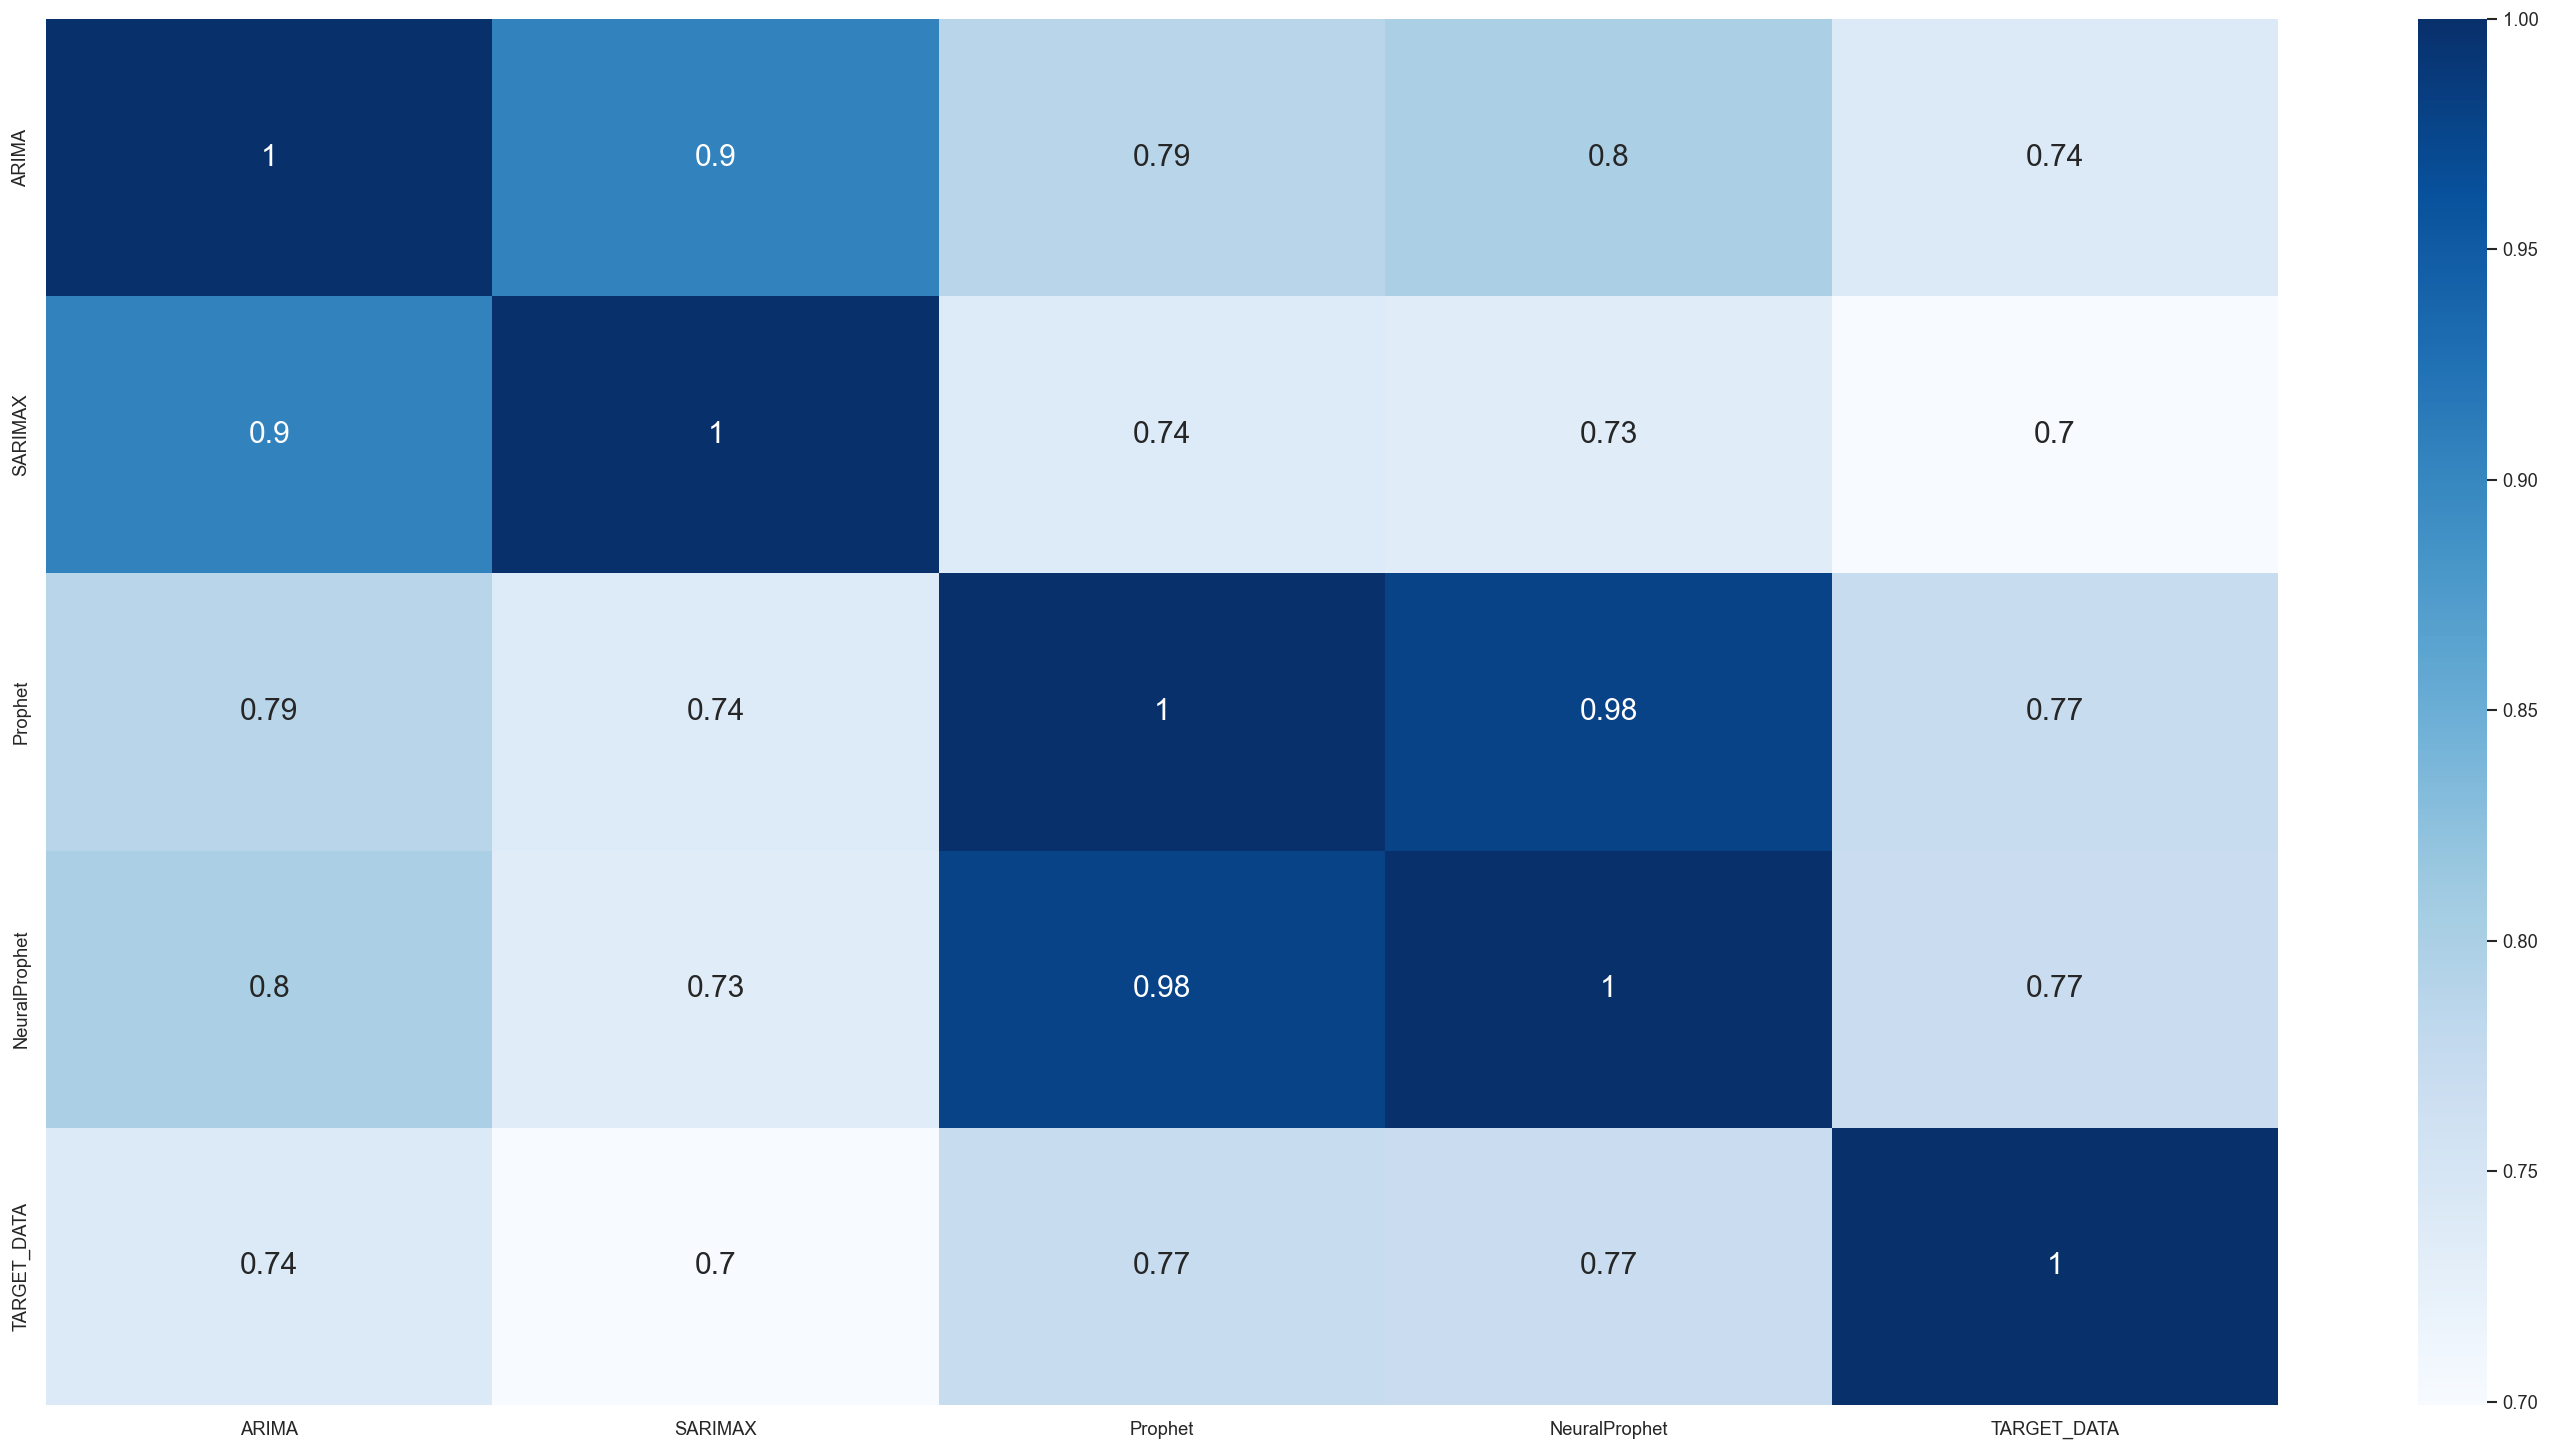

In [275]:
plt.figure(figsize=(30,15))
modelmap = pd.DataFrame({'ARIMA':forecast_arima, 
'SARIMAX': forecast_sarimax, 
'Prophet': forecast_prophet.yhat.values, 
'ARIMA': forecast_arima, 
'NeuralProphet': forecast_neuralprohet.yhat1.values,
'TARGET_DATA': test.y.values})
ax = sns.heatmap(modelmap.corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

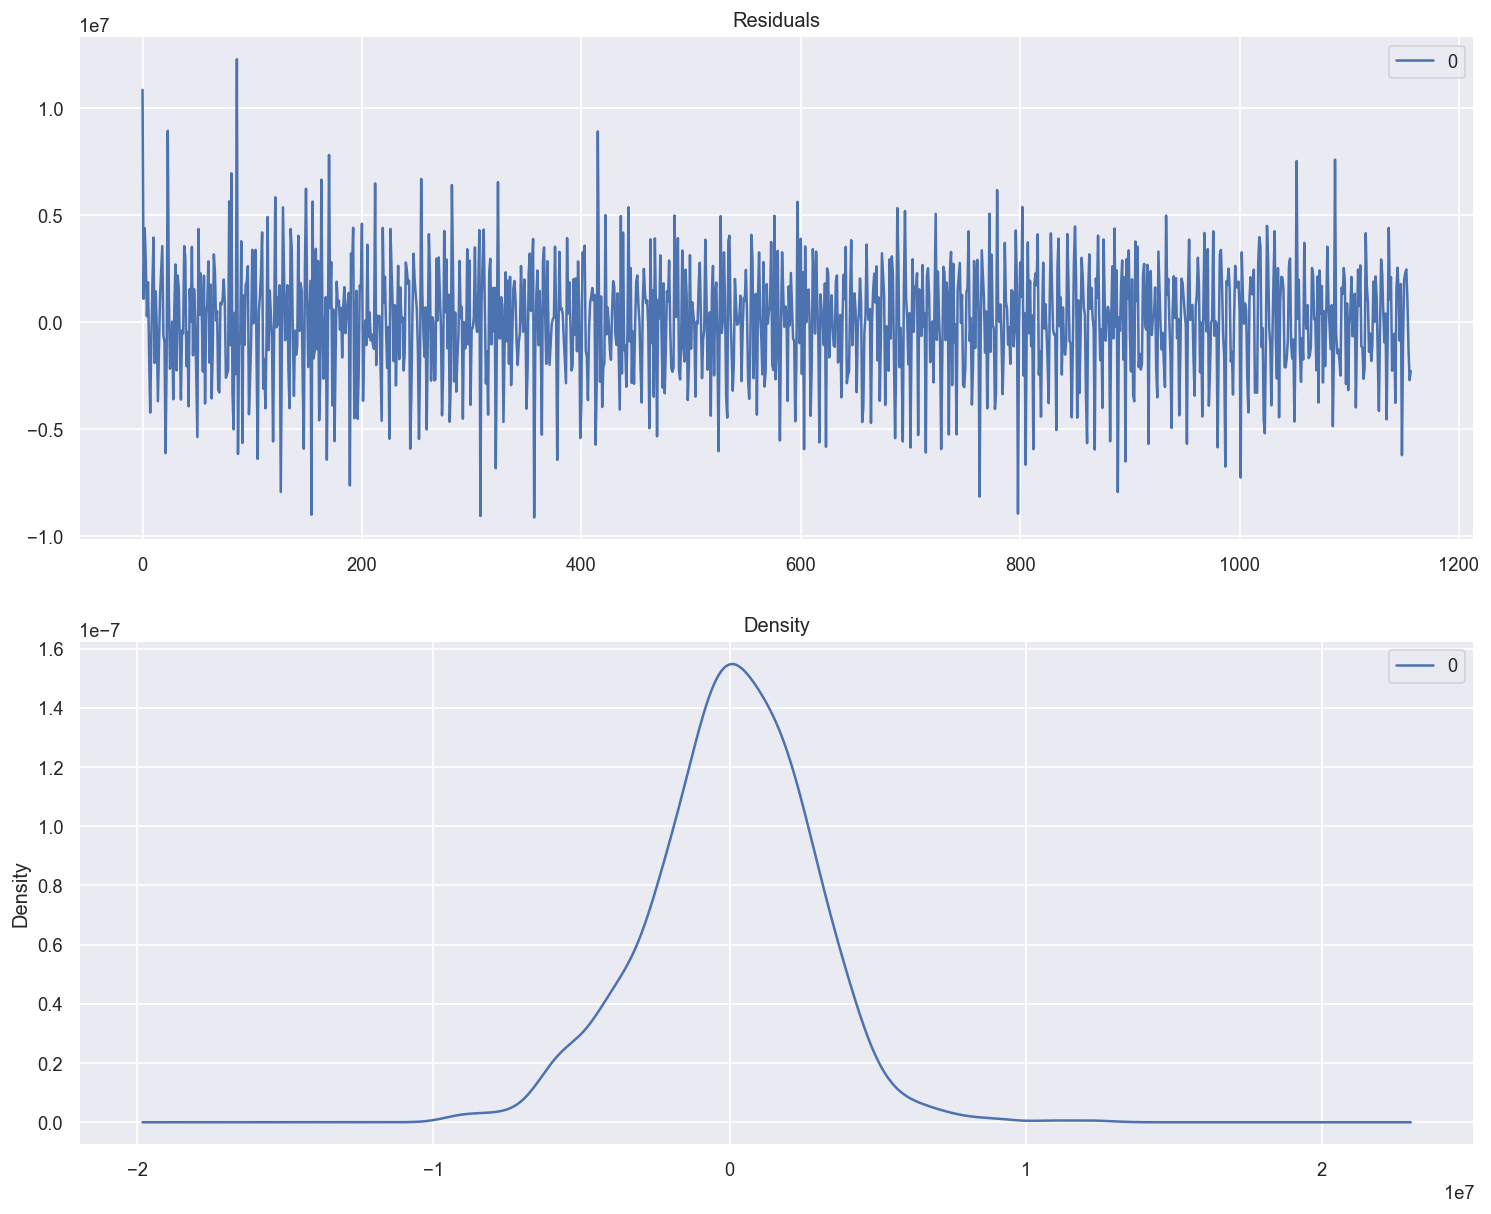

In [ ]:
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(2, 1)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

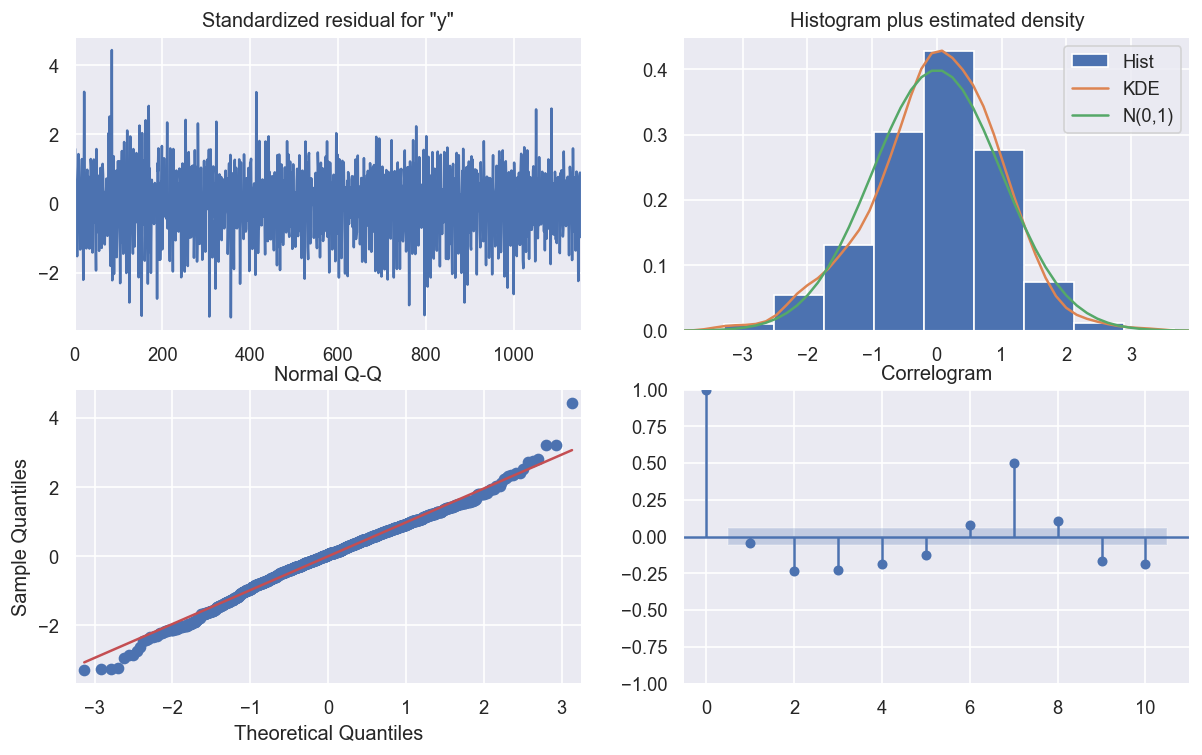

In [ ]:
fitted.plot_diagnostics(figsize=(12,7))
plt.show()

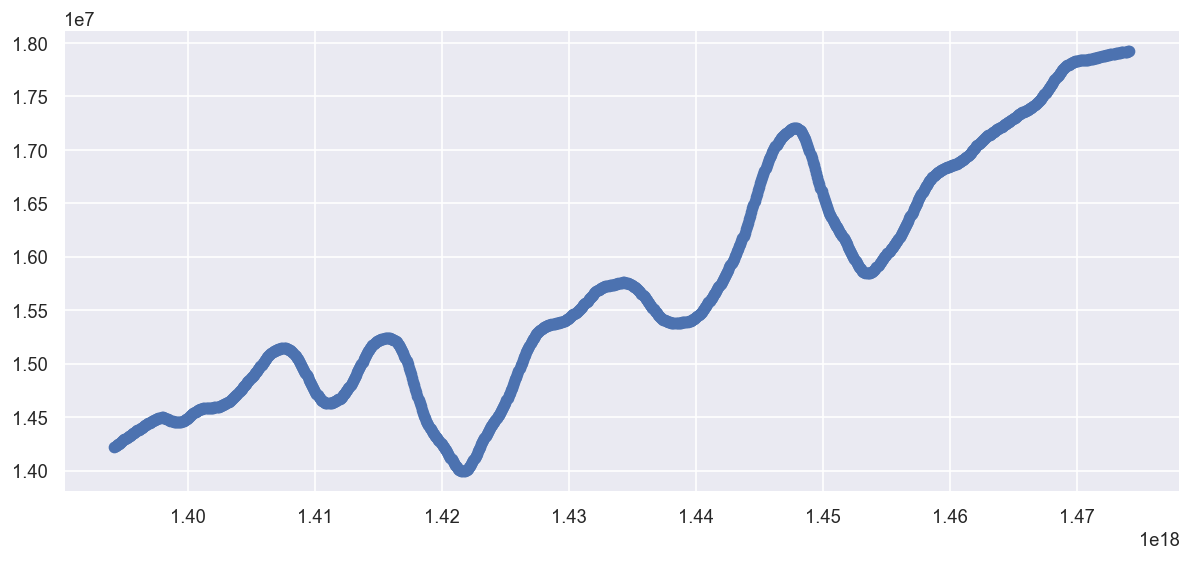

In [ ]:
lowess = sm.nonparametric.lowess
z = lowess(y_train.values, x_train.values, frac=0.1)
plt.figure(figsize = (12,5))
plt.scatter(z[:,0], z[:,1])
plt.show()